In [448]:
#import necessary libraries
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import scipy.ndimage as nd
from tensorflow import keras
%matplotlib inline
import pylab as pl
from IPython import display


import sys
sys.path.append("..") # Adds higher directory to python modules path.

import branchingdnn as branching
from branchingdnn import core
from branchingdnn.utils import * 
from branchingdnn.profiler import model_profiler as profiler
from branchingdnn.dataset import prepare
from branchingdnn.branches import branch

# from tensorflow.examples.tutorials.mnist import input_data

In [449]:
# Download MNIST dataset
# mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
# print(y_train)
K= 10 # number of classes

In [450]:
train_images = train_images.reshape(60000, 784).astype("float32") / 255
test_images = test_images.reshape(10000, 784).astype("float32") / 255


train_labels = tf.keras.utils.to_categorical(train_labels,10)
test_labels = tf.keras.utils.to_categorical(test_labels,10)

print(len(train_labels))
print(len(test_labels))
print(train_labels[0])
print((test_labels[0]))
# plt.imshow(train_images[1].reshape(228,228)) 
# plt.show()

60000
10000
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [451]:
validation_size = 12000
shuffle_size = 20000
batch_size=128
validation_images, validation_labels = train_images[:validation_size], train_labels[:validation_size] #get the first 5k training samples as validation set
train_images, train_labels = train_images[validation_size:], train_labels[validation_size:] # now remove the validation set from the training set.
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))


def augment_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    # image = tf.image.per_image_standardization(image)
    # Resize images from 32x32 to 277x277
    # image = tf.image.resize(image, (28,28))
    return image, label
train_ds_size = len(list(train_ds))
test_ds_size = len(list(test_ds))
validation_ds_size = len(list(validation_ds))
train_ds = (train_ds.map(augment_images))
validation_ds = (validation_ds.map(augment_images))
test_ds = (test_ds.map(augment_images))

target = tf.data.Dataset.from_tensor_slices((train_labels))
train_ds = tf.data.Dataset.zip((train_ds,target))

v_target = tf.data.Dataset.from_tensor_slices((validation_labels))
validation_ds = tf.data.Dataset.zip((validation_ds,v_target))

t_target = tf.data.Dataset.from_tensor_slices((test_labels))
test_ds = tf.data.Dataset.zip((test_ds,t_target))


print("trainSize {}".format(train_ds_size))
print("testSize {}".format(test_ds_size))
train_ds = (train_ds
                
                .shuffle(buffer_size=tf.cast(shuffle_size,'int64'))
                .batch(batch_size=batch_size, drop_remainder=True))

test_ds = (test_ds
               
                #   .shuffle(buffer_size=train_ds_size)
                .batch(batch_size=1, drop_remainder=True))

validation_ds = (validation_ds
               
                #   .shuffle(buffer_size=validation_ds_size)
                .batch(batch_size=batch_size, drop_remainder=True))



trainSize 48000
testSize 10000


In [468]:
# This function to generate evidence is used for the first example
def relu_evidence(logits):
    return tf.nn.relu(logits)

# This one usually works better and used for the second and third examples
# For general settings and different datasets, you may try this one first
def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits,-10,10))

# This one is another alternative and 
# usually behaves better than the relu_evidence 
def softplus_evidence(logits):
    return tf.nn.softplus(logits)
    
def KL(alpha):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)
    
    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)
    
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    # print("kl", kl)
    return kl

def loss_function():
    #create a wrapper function that returns a function
    temperature = 1
    Classes = 10
    keras_kl = tf.keras.losses.KLDivergence()
    def mse_loss(labels, alpha): 
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S

        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 

#         annealing_coef = tf.minimum(1.0,tf.cast(global_step/annealing_step,tf.float32))
        annealing_coef = 1
        alp = E*(1-labels) + 1 
        # print("alp", alp)
#         C =  annealing_coef * KL(alp)
#         print(alpha)
        C = keras_kl(labels, alpha)
        return (A + B) + C
    return  mse_loss



In [469]:
class EvidenceEndpoint(keras.layers.Layer):
        def __init__(self, num_outputs, name=None, **kwargs):
            super(EvidenceEndpoint, self).__init__(name=name)
            self.num_outputs = num_outputs
#             self.kl = tf.keras.losses.KLDivergence()
            self.loss_fn = loss_function()
#             self.loss_fn = tf.keras.losses.categorical_crossentropy
            self.evidence = exp_evidence
            self.temperature = 10
            self.lmb = 0.005
        def build(self, input_shape):
            self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]), self.num_outputs])
        
        def get_config(self):
            config = super().get_config().copy()
            config.update({
                'num_outputs': self.num_outputs,
                'name': self.name
            })
            return config

        def call(self, inputs, labels):
            outputs = tf.matmul(inputs,self.kernel)
#             print(outputs)
            softmax = tf.nn.softmax(outputs)
#             print(softmax)
#             print(labels)
            evidence = exp_evidence(outputs)
            alpha = evidence + 1

            loss = tf.reduce_mean(self.loss_fn(labels, alpha))
            u = self.num_outputs / tf.reduce_sum(alpha, axis=1, keepdims=True) #uncertainty
            prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
            l2_loss = tf.nn.l2_loss(self.weights) * self.lmb
            total_loss = loss + l2_loss
            self.add_loss(total_loss)
#             print("labels", labels)

#             
            
#             

            pred = tf.argmax(outputs,1)
# #             print("pred", pred)
#             results = tf.one_hot(pred,self.num_outputs)
            truth = tf.argmax(labels,1)
# #             print("truth", truth)
            match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
# #             print("match", match)
            total_evidence = tf.reduce_sum(evidence,1, keepdims=True)
            mean_avg = tf.reduce_mean(total_evidence)
            mean_succ = tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*match) / tf.reduce_sum(match+1e-20)
            mean_fail = tf.reduce_sum(tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*(1-match)) / (tf.reduce_sum(tf.abs(1-match))+1e-20) )




            self.add_metric(evidence, name=self.name+"_evidence")
            self.add_metric(mean_avg, name=self.name+"_mean_ev_avg")
            self.add_metric(mean_succ, name=self.name+"_mean_ev_succ")
            self.add_metric(mean_fail, name=self.name+"_mean_ev_fail")
            
            
#             total_loss =tf.reduce_mean(normal_loss) + l2_loss
            # print(total_loss)
#             total_evidence = tf.reduce_sum(evidence,1, keepdims=True) 
            # print(total_evidence)
#             pred = tf.argmax(outputs, 1)
#             truth = tf.argmax(labels, 1)
#             match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
#             # print("match",match)
#             
#             # print("mean_Avg")


            # print('metrics')
#             self.add_loss(total_loss)
            # print("pred",inputs)
            # print("loss")
     
            
            return softmax
    

In [470]:
outputs =[]
inputs = keras.Input(shape=(784,))
targets = keras.Input(shape=(10,),name='targets')
x = layers.Flatten(input_shape=(28,28))(inputs)
x = layers.Dense(512, activation="relu")(x)
x= layers.Dropout(0.2)(x)
#exit 2
x = layers.Dense(512, activation="relu")(x)
x= layers.Dropout(0.2)(x)
#exit 3
x = layers.Dense(512, activation="relu")(x)
x= layers.Dropout(0.2)(x)
#exit 4
x = layers.Dense(512, activation="relu")(x)
x= layers.Dropout(0.2)(x)
#exit 5
x = layers.Dense(512, activation="relu")(x)
x= layers.Dropout(0.2)(x)
#exit 1 The main branch exit is refered to as "exit 1" or "main exit" to avoid confusion when adding addtional exits
# output1 = layers.Dense(10, name="output1")(x)
# softmax = layers.Softmax()(output1)
output = EvidenceEndpoint(10, activation='relu')(x,targets)

outputs.append(output)
print(len(outputs))
model = keras.Model(inputs=[inputs,targets], outputs=output, name="mnist_model_normal")
model.summary()
#visualize_model(model,"mnist_normal")
print(len(model.outputs))


1
Model: "mnist_model_normal"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_90 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
flatten_89 (Flatten)            (None, 784)          0           input_90[0][0]                   
__________________________________________________________________________________________________
dense_445 (Dense)               (None, 512)          401920      flatten_89[0][0]                 
__________________________________________________________________________________________________
dropout_445 (Dropout)           (None, 512)          0           dense_445[0][0]                  
_______________________________________________________________________________

In [471]:
model.compile(  optimizer=tf.optimizers.Adam(), metrics=['accuracy'],run_eagerly=True)
model.fit(train_ds,
          epochs=50,
          validation_data=validation_ds,
          validation_freq=5)

Epoch 1/47
375/375 [==============================] - 10s 27ms/step - loss: 0.3302 - accuracy: 0.7753 - evidence_endpoint_88_evidence: 1155.1278 - evidence_endpoint_88_mean_ev_avg: 11551.2783 - evidence_endpoint_88_mean_ev_succ: 12410.7480 - evidence_endpoint_88_mean_ev_fail: 2201.8762
Epoch 2/47
375/375 [==============================] - 10s 27ms/step - loss: 0.0927 - accuracy: 0.9506 - evidence_endpoint_88_evidence: 1566.9426 - evidence_endpoint_88_mean_ev_avg: 15669.4258 - evidence_endpoint_88_mean_ev_succ: 16312.5469 - evidence_endpoint_88_mean_ev_fail: 3128.7078
Epoch 3/47
375/375 [==============================] - 10s 27ms/step - loss: 0.0762 - accuracy: 0.9567 - evidence_endpoint_88_evidence: 1670.7638 - evidence_endpoint_88_mean_ev_avg: 16707.6367 - evidence_endpoint_88_mean_ev_succ: 17271.9824 - evidence_endpoint_88_mean_ev_fail: 3037.9033
Epoch 4/47
375/375 [==============================] - 10s 27ms/step - loss: 0.0629 - accuracy: 0.9645 - evidence_endpoint_88_evidence: 1762

Epoch 26/47
375/375 [==============================] - 10s 27ms/step - loss: 0.0293 - accuracy: 0.9848 - evidence_endpoint_88_evidence: 2124.9822 - evidence_endpoint_88_mean_ev_avg: 21249.8223 - evidence_endpoint_88_mean_ev_succ: 21432.6309 - evidence_endpoint_88_mean_ev_fail: 7336.7354
Epoch 27/47
375/375 [==============================] - 10s 27ms/step - loss: 0.0268 - accuracy: 0.9860 - evidence_endpoint_88_evidence: 2128.6245 - evidence_endpoint_88_mean_ev_avg: 21286.2441 - evidence_endpoint_88_mean_ev_succ: 21455.6855 - evidence_endpoint_88_mean_ev_fail: 8386.3604
Epoch 28/47
375/375 [==============================] - 10s 27ms/step - loss: 0.0323 - accuracy: 0.9835 - evidence_endpoint_88_evidence: 2141.0378 - evidence_endpoint_88_mean_ev_avg: 21410.3789 - evidence_endpoint_88_mean_ev_succ: 21585.5977 - evidence_endpoint_88_mean_ev_fail: 9784.8750
Epoch 29/47
375/375 [==============================] - 10s 27ms/step - loss: 0.0315 - accuracy: 0.9842 - evidence_endpoint_88_evidence: 

In [478]:
model.evaluate(test_ds)

10000/10000 [==============================] - 146s 15ms/step - loss: 0.0374 - accuracy: 0.9805 - evidence_endpoint_88_evidence: 2167.6917 - evidence_endpoint_88_mean_ev_avg: 21676.9160 - evidence_endpoint_88_mean_ev_succ: 21426.5234 - evidence_endpoint_88_mean_ev_fail: 250.3299


[0.037376947700977325,
 0.9804999828338623,
 2167.691650390625,
 21676.916015625,
 21426.5234375,
 250.3298797607422]

In [442]:
# model.save("mnist_notebook.hdf5")

In [474]:
def displayEvidence(model,test_ds):
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
#     train_ds, test_ds, validation_ds = (dataset)
    predictions = []
    labels = []
    iterator = iter(test_ds)
    print(len(test_ds))
    item = iterator.get_next()
#     print(item)

    pClass = []
    predictions=[]
    pEvidence = []
    pAcc=[]
#     for i in range(len(test_ds)-1):
    for i in range(1000):
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        item = iterator.get_next()
#         prediction = model.predict(item[0])
        x = model.test_on_batch(item[0],item[1])
#         print("accuracy:", x[1], "evidence:",x[2])
        pClass.append(tf.argmax(item[1],1).numpy()[0])
        pEvidence.append(x[2])
        pAcc.append(x[1])       
#     print(pClass)
#     print(pEvidence)
#     print(pAcc)
    Predictions = pd.DataFrame({"class":pClass,"evidence":pEvidence,"Acc":pAcc})
    
#     print(Predictions)
    
    correct_rows = Predictions.loc[Predictions['Acc'] == True]
    incorrect_rows = Predictions.loc[Predictions['Acc'] == False]
    
#     print(correct_rows)
#     print(incorrect_rows)
    
    fig, axs = plt.subplots(1, 2)
    fig.suptitle('Horizontally stacked subplots')
    axs[0].scatter(correct_rows['class'],correct_rows['evidence'],c ='r',marker='+')
    axs[0].scatter(incorrect_rows['class'],incorrect_rows['evidence'],c ='k',marker='x')
    axs[0].set_title("evidence")

#     axs[1].scatter(predEvidence_true_label,predEvidence_true_uncert,c ='r',marker='*')
#     axs[1].scatter(predEvidence_fail_label,predEvidence_fail_uncert,c ='k',marker='*')
#     axs[1].set_title("uncertainty")

    fig.set_size_inches(10, 10)
    plt.show()
    return Predictions


10000


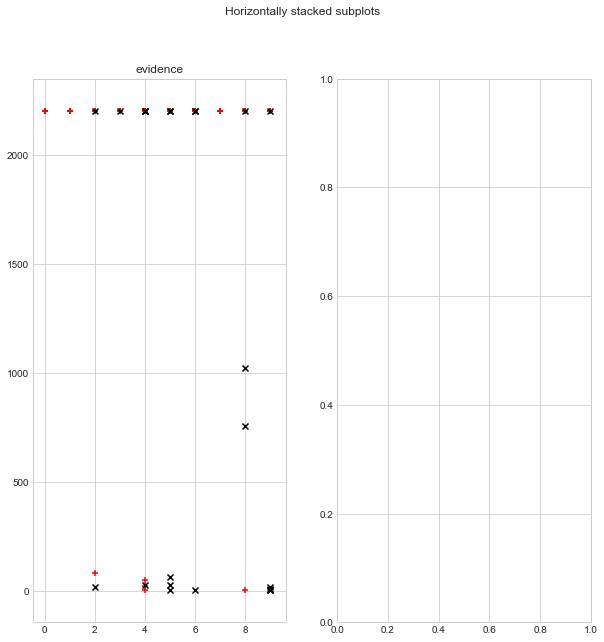

In [475]:
###keras KL activated model 47 epochs
Predictions = displayEvidence(model,test_ds)

10000


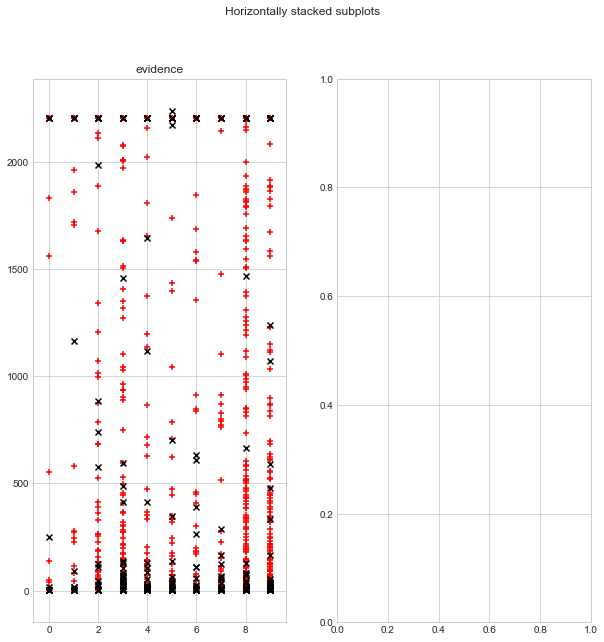

In [400]:
### no KL 
Predictions = displayEvidence(model,test_ds)

In [476]:
# threshold = 000
Predictions['uncertainty'] = 10 / (10+Predictions['evidence'])
correct_rows = Predictions.loc[(Predictions['Acc'] == True) & (Predictions['evidence'] >threshold)]
incorrect_rows = Predictions.loc[(Predictions['Acc'] == False) & (Predictions['evidence'] > threshold)]
# incorrect_rows = Predictions.loc[(Predictions['evidence'] > 40)]
print(correct_rows.count())

print(incorrect_rows.count())
print(incorrect_rows.head())
# print(incorrect_rows.sort_values("evidence"))

uncertainty_correct_rows = Predictions.loc[(Predictions['Acc'] == True) & (Predictions['evidence'] >threshold)]
uncertainty_incorrect_rows = Predictions.loc[(Predictions['Acc'] == False) & (Predictions['evidence'] > threshold)]


class          977
evidence       977
Acc            977
uncertainty    977
dtype: int64
class          23
evidence       23
Acc            23
uncertainty    23
dtype: int64
     class     evidence  Acc  uncertainty
7        5  2202.646973  0.0     0.004519
148      2    16.042336  0.0     0.383990
150      9    16.741848  0.0     0.373946
246      4  2202.646729  0.0     0.004519
258      6  2202.646729  0.0     0.004519


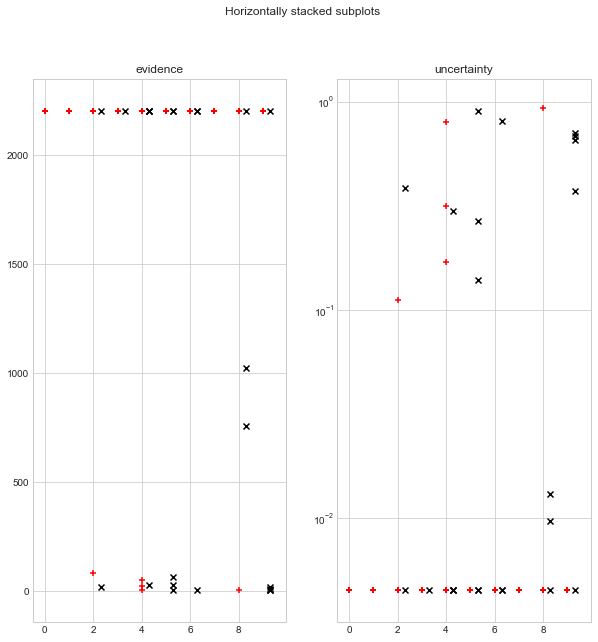

In [477]:
fig, axs = plt.subplots(1, 2)
plt.yscale('log')
fig.suptitle('Horizontally stacked subplots')
axs[0].scatter(correct_rows['class'],correct_rows['evidence'],c ='r',marker='+')
axs[0].scatter(incorrect_rows['class']+.3,incorrect_rows['evidence'],c ='k',marker='x')
axs[0].set_title("evidence")

axs[1].scatter(correct_rows['class'],correct_rows['uncertainty'],c ='r',marker='+')
axs[1].scatter(incorrect_rows['class']+.3,incorrect_rows['uncertainty'],c ='k',marker='x')
axs[1].set_title("uncertainty")
fig.set_size_inches(10, 10)


In [441]:
def GetResultsCSV_evidence(model,dataset,suffix="", validation=True):
        num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
        train_ds, test_ds, validation_ds = (dataset)
        predictions = []
        labels = []
        #already compiled
        # model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])
        iterator = iter(test_ds)
        print(len(test_ds))

#         for j in range(len(test_ds)):
        for j in range(100):
            print("prediction: {} of {}".format(j,len(test_ds)),end='\r')
            item = iterator.get_next()
            prediction = model.predict(item[0])
            # print("predictions {}".format(prediction))
            predictions.append(prediction)
            # print(prediction)
            labels.append(item[1].numpy().tolist())
        print("labels")
        # print(labels)
        for i, val in enumerate(labels):
            # print(i)
            labels[i]= [np.argmax(val)]* num_outputs

        predEvidence_fail =[]
        predEvidence_fail_uncert =[]
        predEvidence_true = []
        predEvidence_true_uncert =[]
        predEvidence_fail_label =[]
        predEvidence_true_label =[]
        predClasses =[]
        predRaw=[]
        print("predictions complete, analyizing") 
        for i,output in enumerate(predictions):
            for k, pred in enumerate(output):

                pred_classes=[]
                pred_evidence = []
                pred_Raw=[]
                print("image: {} of {}".format(i,len(predictions)),end='\r')
                # print("output: ",i)
                if(type(pred[0])==list):
                    for l, branch in enumerate(pred):
                        pred_Raw.append(branch)
                        Pclass = np.argmax(branch)
                        pred_classes.append(Pclass) 
                        evidence = exp_evidence(branch).numpy()
                        total_evidence = evidence
                        match = tf.reshape(tf.cast(tf.equal(Pclass, labels[i]), tf.float32),(-1,1))                    
                        if l !=0:
                            if match.numpy()[0]==0:
                                # print("match", match.numpy(),total_evidence.numpy())
                                
                                ev_fail = evidence + 1
                                predEvidence_fail.append(ev_fail.numpy())
                                predEvidence_fail_uncert.append(K / ev_fail.numpy())
                                predEvidence_fail_label.append(labels[i][0])
                            else:
                                # print(labels[i])

                                ev_succ = evidence
                                predEvidence_true.append(ev_succ)
                                predEvidence_true_uncert.append(K /ev_succ.numpy())
                                predEvidence_true_label.append(labels[i][0])
                                                
                            # print(total_evidence.numpy())
                        pred_evidence.append(total_evidence)
                else:
                    # print("predictions", pred)

                    pred_Raw.append(pred)
                    Pclass = np.argmax(pred)
                    pred_classes.append(Pclass) 
                    evidence = tf.reduce_sum(exp_evidence(pred)).numpy()
                    # print(evidence)
                    total_evidence = evidence
                    match = tf.reshape(tf.cast(tf.equal(Pclass, labels[i]), tf.float32),(-1,1))  
                    # print(match)                  
                    if match.numpy()[0]==0:
                        # print("fail")
                        # print("match", match.numpy(),total_evidence.numpy())
                        
                        ev_fail = (evidence)*(1-0) / (1+1e-20) 
                        predEvidence_fail.append(ev_fail)
                        predEvidence_fail_uncert.append(K/ (K + ev_fail))
                        predEvidence_fail_label.append(labels[i][0])
                    else:
                        # print(labels[i])

                        ev_succ = (evidence)*1 / (1+1e-20)
                        predEvidence_true.append(ev_succ)
                        predEvidence_true_uncert.append(K/ (K + ev_succ))
                        predEvidence_true_label.append(labels[i][0])
                                            
                        # print(total_evidence.numpy())
                    pred_evidence.append(total_evidence)
        
              
        labelClasses = [0,1,2,3,4,5,6,7,8,9]
        # predClasses = pd.DataFrame(predClasses)
        labels = pd.DataFrame(labels)
        predEvidence_fail = pd.DataFrame([predEvidence_fail])
        predEvidence_true = pd.DataFrame([predEvidence_true])
        
        import matplotlib.pyplot as plt

        # predEvidence_true = [K / K+ x for x in predEvidence_true]
        # predEvidence_fail = [K / K+ x for x in predEvidence_fail]

        # print(len(predEvidence_true))
        # print(len(predEvidence_true_label))
        print("mean Success: ",tf.reduce_mean(predEvidence_true))
        # print(predEvidence_true)
        print("mean Fail: ",tf.reduce_mean(predEvidence_fail))

        predEvidence_fail_label = [x+.2 for x in predEvidence_fail_label]
        fig, axs = plt.subplots(1, 2)
        fig.suptitle('Horizontally stacked subplots')
        axs[0].scatter(predEvidence_true_label,predEvidence_true,c ='r',marker='+')
        axs[0].scatter(predEvidence_fail_label,predEvidence_fail,c ='k',marker='x')
        axs[0].set_title("evidence")

        axs[1].scatter(predEvidence_true_label,predEvidence_true_uncert,c ='r',marker='*')
        axs[1].scatter(predEvidence_fail_label,predEvidence_fail_uncert,c ='k',marker='*')
        axs[1].set_title("uncertainty")

        fig.set_size_inches(10, 10)
        plt.show()
        
        
        
        return
        
        

10000
labelstion: 9999 of 10000
predictions complete, analyizing
mean Success:  tf.Tensor(11.712669773054586, shape=(), dtype=float64)
mean Fail:  tf.Tensor(11.542338025336171, shape=(), dtype=float64)


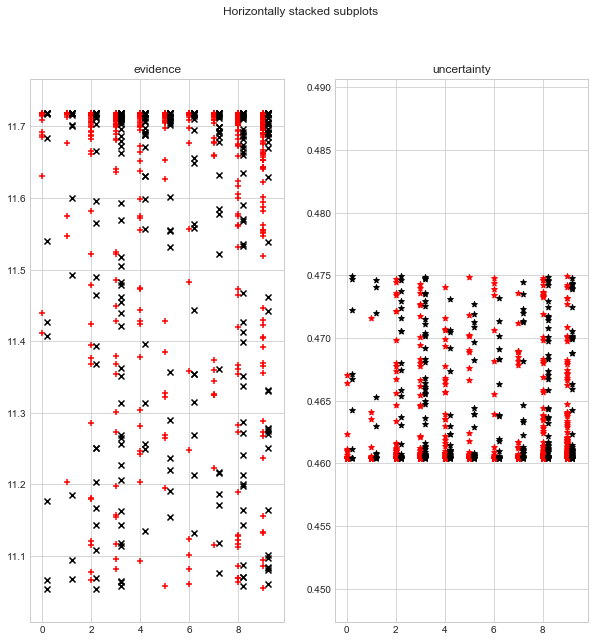

In [272]:
results = GetResultsCSV_evidence(model,(train_ds, test_ds, validation_ds),suffix="new_model", validation=True)

10000
labelstion: 99 of 10000
predictions complete, analyizing
mean Success:  tf.Tensor(11.716626070966624, shape=(), dtype=float64)
mean Fail:  tf.Tensor(11.55577278137207, shape=(), dtype=float64)


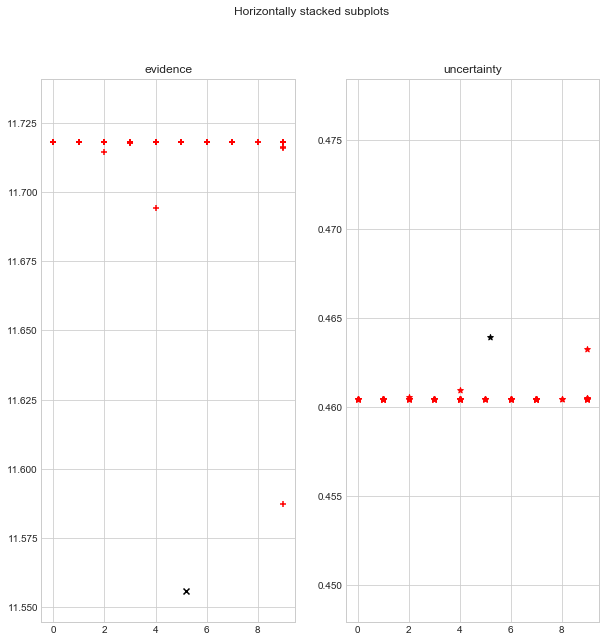

In [274]:
results = GetResultsCSV_evidence(model,(train_ds, test_ds, validation_ds),suffix="new_model", validation=True)

In [425]:
results.head()

AttributeError: 'NoneType' object has no attribute 'head'